In [ ]:
# Storm Damage Prediction Model (Improved Version)

# 1. Import dependencies
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from math import radians, sin, cos, sqrt, asin  # for Haversine (optional)

# 2. Load dataset
df = pd.read_csv('StormEvents_cleaned.csv')

print("✅ Dataset loaded | Shape:", df.shape)

# 3. Convert DAMAGE_PROPERTY and DAMAGE_CROPS to numeric
def convert_damage(value):
    if pd.isna(value):
        return 0.0
    v = str(value).strip().upper()
    if v in ["", "0", "0.0", "NONE", "NA", "NAN"]:
        return 0.0
    multiplier = 1.0
    if v[-1] in ["K", "M", "B"]:
        suffix = v[-1]
        num = v[:-1]
        if suffix == "K":
            multiplier = 1_000.0
        elif suffix == "M":
            multiplier = 1_000_000.0
        elif suffix == "B":
            multiplier = 1_200_000_000.0  # cap billions
    else:
        num = v.replace(",", "")
    try:
        return float(num) * multiplier
    except:
        import re
        num_only = re.sub(r"[^0-9\.]", "", v)
        if num_only == "":
            return 0.0
        return float(num_only) * multiplier

df["DAMAGE_PROPERTY"] = df["DAMAGE_PROPERTY"].apply(convert_damage).clip(upper=1_200_000_000)
df["DAMAGE_CROPS"] = df["DAMAGE_CROPS"].apply(convert_damage).fillna(0.0)

# Drop potentially leak-prone or unusable columns
df = df.drop(columns=[
    "EPISODE_NARRATIVE", "EVENT_NARRATIVE", "DAMAGE_PROPERTY_NUM"
], errors="ignore")

# 4. Calculate DURATION_HOURS
df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'], errors='coerce')
df['END_DATE_TIME'] = pd.to_datetime(df['END_DATE_TIME'], errors='coerce')
df['DURATION_HOURS'] = (df['END_DATE_TIME'] - df['BEGIN_DATE_TIME']).dt.total_seconds() / 3600.0
df['DURATION_HOURS'] = df['DURATION_HOURS'].fillna(0.0)

# Filter rows with missing lat/lon
df = df.dropna(subset=['BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON'])

# 5. Select features
selected_features = [
    "STATE", "EVENT_TYPE", "MONTH_NAME",
    "MAGNITUDE", "MAGNITUDE_TYPE",
    "BEGIN_LAT", "BEGIN_LON",
    "DURATION_HOURS"
]
selected_features = [f for f in selected_features if f in df.columns]

df_model = df[selected_features + ["DAMAGE_PROPERTY"]].copy()
print("📌 Selected Features:", selected_features)

# 6. Split numeric and categorical features
numeric_features = [col for col in selected_features if pd.api.types.is_numeric_dtype(df_model[col])]
categorical_features = [col for col in selected_features if col not in numeric_features]

# 7. Preprocessing Pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# 8. Model pipeline
model = GradientBoostingRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=10,
    learning_rate=0.05,
    loss='huber'
)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

# 9. Log-transform target
y = df_model["DAMAGE_PROPERTY"]
y_log = np.log1p(y)
X = df_model[selected_features]

# 10. Stratified Train-Test Split
df_model["damage_bin"] = pd.qcut(df_model["DAMAGE_PROPERTY"], q=5, labels=False, duplicates='drop')
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df_model["damage_bin"]
)
print("📊 Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# 11. Train the model
pipeline.fit(X_train, y_train_log)
cv_scores = cross_val_score(pipeline, X_train, y_train_log, cv=5, scoring='r2')
print(f"CV Mean R²: {np.mean(cv_scores):.4f}")

# 12. Evaluate the model
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)

print("\n📈 Final Model Performance:")
print(f"MAE: {mae:,.2f} USD")
print(f"MedAE: {medae:,.2f} USD")
print(f"RMSE: {rmse:,.2f} USD")

# # 13. Save model and metrics
# joblib.dump(pipeline, "damage_model_pipeline.pkl")
# print("Model saved to: damage_model_pipeline.pkl")

metrics = {
    "MAE": mae,
    "MedAE": medae,
    "RMSE": rmse,
    "CV_R2": float(np.mean(cv_scores))
}
with open("damage_model_metrics.json", "w") as f:
    json.dump(metrics, f)
print("Metrics saved to: damage_model_metrics.json")


✅ Dataset loaded | Shape: (43070, 52)


C:\Users\anuda\AppData\Local\Temp\ipykernel_4524\3563344999.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'], errors='coerce')
C:\Users\anuda\AppData\Local\Temp\ipykernel_4524\3563344999.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['END_DATE_TIME'] = pd.to_datetime(df['END_DATE_TIME'], errors='coerce')


📌 Selected Features: ['STATE', 'EVENT_TYPE', 'MONTH_NAME', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'BEGIN_LAT', 'BEGIN_LON', 'DURATION_HOURS']
📊 Train shape: (20536, 8) | Test shape: (5134, 8)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

# If you have y_pred and y_true already (make sure they're NOT log-transformed)
mae = mean_absolute_error(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (skip 0s to avoid division by zero)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-10, None))) * 100

# SMAPE (Symmetric MAPE)
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-10))

# RMSLE (you must clip to avoid log(0))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Print them
print("\n📈 Additional Accuracy Metrics:")
print(f"MAE    : {mae:,.2f} USD")
print(f"MedAE  : {medae:,.2f} USD")
print(f"RMSE   : {rmse:,.2f} USD")
print(f"RMSLE  : {rmsle:.4f}")



📈 Additional Accuracy Metrics:
MAE    : 441.58 USD
MedAE  : 0.11 USD
RMSE   : 1,162.71 USD
RMSLE  : 2.0463


In [9]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    median_absolute_error,
    mean_squared_error
)

# Ensure predictions and true values are in original scale
# y_pred and y_true should already be defined and not log-transformed

# Core regression metrics
mae = mean_absolute_error(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Optional: WAPE (stable % error metric)
wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

# Print summary
print("\n📊 Final Model Evaluation (Stable Metrics):")
print(f"MAE    : {mae:,.2f} USD")
print(f"MedAE  : {medae:,.2f} USD")
print(f"RMSE   : {rmse:,.2f} USD")
print(f"RMSLE  : {rmsle:.4f}")
print(f"WAPE   : {wape * 100:.2f}%")



📊 Final Model Evaluation (Stable Metrics):
MAE    : 441.58 USD
MedAE  : 0.11 USD
RMSE   : 1,162.71 USD
RMSLE  : 2.0463
WAPE   : 68.14%


C:\Users\anuda\AppData\Local\Temp\ipykernel_27420\3825842770.py:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\anconda\envs\foml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


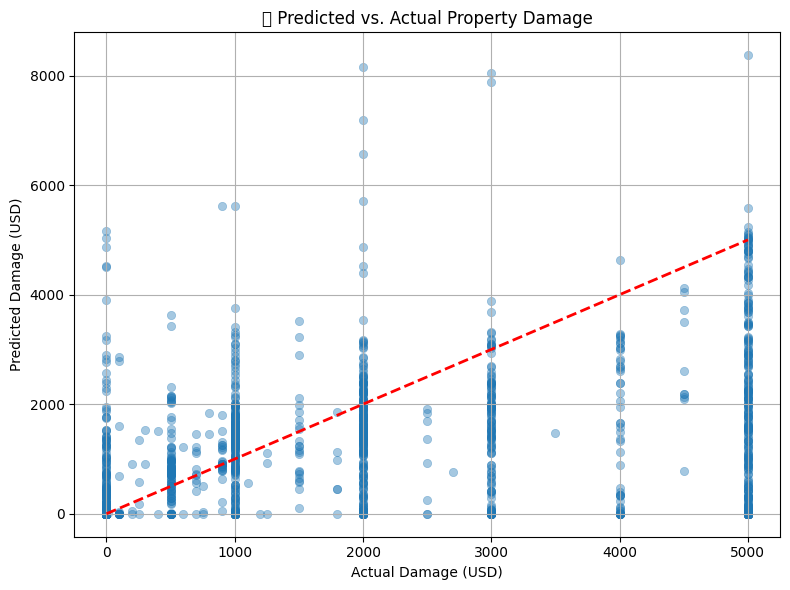

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.4, edgecolor=None)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel("Actual Damage (USD)")
plt.ylabel("Predicted Damage (USD)")
plt.title("🔍 Predicted vs. Actual Property Damage")
plt.grid(True)
plt.tight_layout()
plt.show()


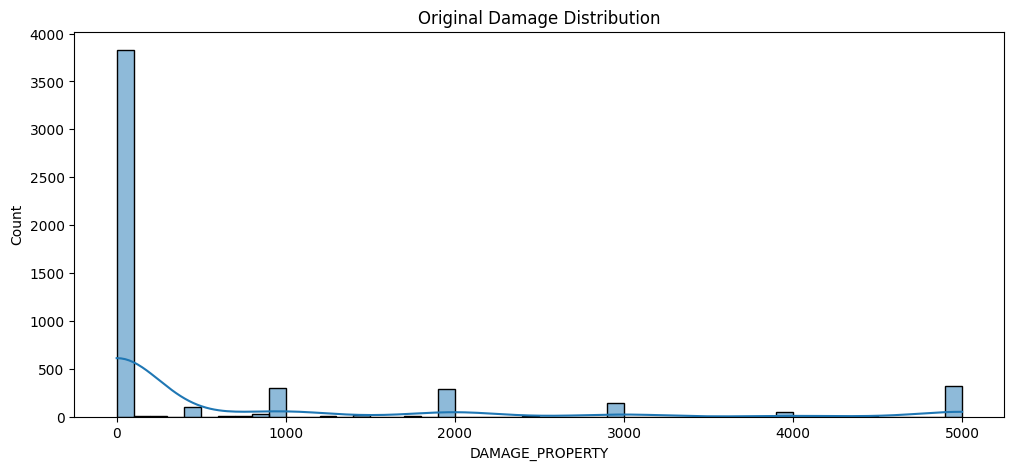

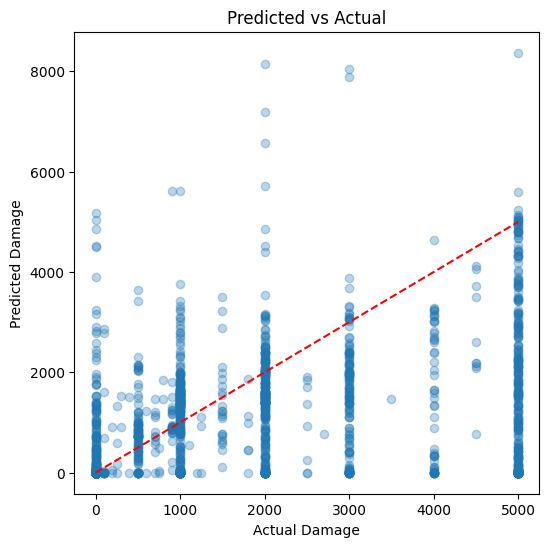

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of damages (original vs log)
fig, ax = plt.subplots(1, figsize=(12, 5))
sns.histplot(y_true, bins=50, ax=ax, kde=True)
ax.set_title("Original Damage Distribution")
plt.show()

# 2. Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Damage")
plt.ylabel("Predicted Damage")
plt.title("Predicted vs Actual")
plt.show()

# Update font cache to prevent missing glyph warnings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.gcf().canvas.draw() # Redraw figure to apply font changes

In [12]:
joblib.dump(pipeline, "damage_model_pipeline.pkl")
print("✅ Model pipeline saved as 'damage_model_pipeline.pkl'")

✅ Model pipeline saved as 'damage_model_pipeline.pkl'
